In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.stats as stats

import seaborn as sns
import json
import openai
import random
import os
import collections
import itertools
import copy
import dataloader
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import netgraph
import scipy
import ast

MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']


# gpt-4-1106-preview

def get_response(prompt, model='gpt-4-1106-preview', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']


def summarize_reasons(filenames, name, n_samples=50, n_categories=4, n_resamples=5, categories=None, model='gpt-4-1106-preview'):
    random.seed(1)
    np.random.seed(1)

    reason_list = collections.defaultdict(list)

    all_reasons = []

    for filename in filenames:
        data = []

        with open(filename) as f:
            lines = f.read().splitlines()


        for line in lines:

            data.append(json.loads(line))


        for d in data:        
            for results in d["results"]:
                for result in results:
                    if result and 'reason' in result.keys():
                        reason_list[d['temperature']].append(result['reason'])
                        all_reasons.append(result['reason'])

    if categories is None:
        categorization_prompt = f"""
        # Task

        You are given a list of reasons and your task to find {n_categories} categories that best describe the reasons.

        # Input

        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(random.sample(all_reasons, len(reason_list) * n_samples))}
        </REASONS>

        # Output

        The output should be given in JSON format with the following structure:

        [
            {{
                "category" : category,
                "description" : short description of the category
            }}, ...
        ]

        # Notes
        * The names of the categories must be descriptive and mutually exclusive.

        ```json
        """

        for _ in range(10):
            try:
                ans = get_response(categorization_prompt, temperature=0, system_prompt="You are a helpful assistant", model=model)
                categories = json.loads(ans.lstrip('```json').rstrip('```'))
                print(categories)
                break

            except Exception as e:
                print(e)
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    category_list = [c['category'] for c in categories]

    records = []

    for i, (k, v) in enumerate(reason_list.items()):
        print('Temperature', k)
        if len(v) <= n_samples:
            n_resamples = 1

        for r in range(n_resamples):
            prompt = f"""
            # Task
            You are given a list of reasons and your task is to classify them into categories.

            # Input
            The input is a list of reasons. The list is given below after chevrons:
            <REASONS>
            {json.dumps(random.sample(v, n_samples), indent=4)}
            </REASONS>

            ## Categories
            The names of the categories are given below after chevrons:
            <CATEGORIES>
            {json.dumps(categories, indent=4)}
            </CATEGORIES>

            Each reason must be assigned to exactly one of the categories.
            
            # Output
            The output should be given as a list of JSON objects with the following structure:

            [
                {{
                        "reason" : reason,
                        "category" : category name
                }}, ...
            ]

            ```json
            """

            for _ in range(10):
                try:
                    ans = get_response(prompt, temperature=0, system_prompt="You are a helpful assistant", model=model)

                    result =  json.loads(ans.lstrip('```json').rstrip('```'))


                    assert(isinstance(result, list))

                    reason_types = collections.defaultdict(float)

                    total = 0

                    for reason in result:
                        if reason['category'] in category_list:
                            reason_types[reason['category']] += 1
                            total += 1

                    for key, val in reason_types.items():
                        reason_types[key] = val / total * 100

                   
                    break
                except Exception as e:
                    print(e)

            for key, val in reason_types.items():
                records.append({
                    'Temperature' : k,
                    'Category' : key,
                    'Frequency' : val,
                    'Resample' : r
                })
            
    df = pd.DataFrame.from_records(records)

    fig.suptitle(f'Reasoning for {name}', fontsize=MEDIUM_SIZE)

    sns.barplot(data=df, x='Category', y='Frequency', hue='Temperature', ax=ax, palette='Set2', hue_order=sorted(reason_list.keys()), order=sorted(category_list))

    plt.legend(fontsize=0.6*SMALL_SIZE, title='Temperature', loc='upper left')

    plt.xticks(rotation=0, fontsize=0.6*SMALL_SIZE)

    # T-test

    for k in sorted(reason_list.keys()):
        for category1, category2 in itertools.combinations(category_list, 2):
            print(f'Temperature: {k}, Category 1: {category1}, Category 2: {category2}')
            print(stats.ttest_ind(df.query(f'Temperature == {k} and Category == "{category1}"')['Frequency'], df.query(f'Temperature == {k} and Category == "{category2}"')['Frequency'], equal_var=False, alternative='greater'))


    fig.tight_layout()

    fig.savefig(f'figures/combined_model/{name}_reasons.png', dpi=300, bbox_inches='tight')

def print_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    for d in data:
        if d["n"] == 50 and d["simulation"] == 0:
            print(f'n = {d["n"]}, simulation = {d["simulation"]}, temperature = {d["temperature"]}')
            
            for result in d["results"]:
                
                    try:
                        print('\t' + result['reason'])
                    except:
                        pass

def network_growth(G0, temperature, num_choices=1, method='llm', num_samples=-1, num_nodes_samples=-1, model='gpt-4-1106-preview'):
    # Set seed
    random.seed(0)
    np.random.seed(0)    

    # Copy the ground truth graph
    G = G0.copy()
   
    Gs = [G.copy()]

    profiles = nx.get_node_attributes(G, 'features')

    # Edges to drop
    dropped_edges = []

    if num_nodes_samples > 0:
        nodes = random.sample(G.nodes(), min(len(G), num_nodes_samples))
    else:
        nodes = G.nodes()

    # Drop one neighbor for each node
    for v in nodes:
        dropped_v_edges = []
        for _ in range(num_choices):
            if len(list(G.neighbors(v))) > 0:
                
                while True:
                    u = random.choice(list(G.neighbors(v)))
                    if (v, u) not in dropped_edges:
                        dropped_v_edges.append((v, u))
                        G.remove_edge(v, u)
                        break

        dropped_edges.append(dropped_v_edges)

    Gs = [G.copy()]
    results = []
    candidates = []


    for i, t in enumerate(nodes):

        if method == 'llm':
            result, candidate = select_neighbor(G, t, profiles, temperature, num_choices=len(dropped_edges[i]), dropped_nodes=[u for (_, u) in dropped_edges[i]], num_samples=num_samples, model=model)

            if result:
                for r in result:
                    v = r['name']
                    r['edge'] = (t, v)
                    G.add_edge(t, v, similarity=r['similarity'])
                results.append(result)

            candidates.append(candidate)
        elif method in ['random', 'homophilous', 'heterophilous', 'ground_truth']:
            if num_samples > 0:
                choice_set = random.sample([v for v in G.nodes() if v != t], num_samples)
            else:
                choice_set = [v for v in G.nodes() if v != t]

            if method == 'random':
                new_nodes = random.sample(choice_set, len(dropped_edges[i]))
            elif method == 'homophilous':
                new_nodes = list(sorted(choice_set, key=lambda v: measure_similarity(profiles[t], profiles[v])['common_attributes'], reverse=True))[:len(dropped_edges[i])]
            elif method == 'heterophilous':
                new_nodes = list(sorted(choice_set, key=lambda v: measure_similarity(profiles[t], profiles[v])['common_attributes']))[:len(dropped_edges[i])]
            elif method == 'ground_truth':
                new_nodes = [e[1] for e in dropped_edges[i]]

            result = []

            for v in new_nodes:
                print(f'Node: {t}, Link: {v}')
                similarity = measure_similarity(profiles[t], profiles[v])
                G.add_edge(t, v, similarity=similarity, weight=similarity['common_attributes'])
            
                result.append({'name' : v, 'similarity' : similarity, 'reason' : method})

            candidate = []

            for v in choice_set:
                similarity = measure_similarity(profiles[t], profiles[v])
                candidate.append({'name' : v, 'similarity' : similarity, 'reason' : method})

            candidates.append(candidate)
            results.append(result)

        Gs.append(G.copy())

    return Gs, results, candidates

def fit_dcm(results):

    similarities = [r['similarity'] for result in results for r in result]
    similarities_df = pd.DataFrame.from_records(similarities)
    similarities_df = sm.add_constant(similarities_df)

    outcomes = np.array([r['edge'][1] for result in results for r in result])

    print(similarities_df)

    mnl_model = sm.MNLogit(outcomes, similarities_df)
    mnl_results = mnl_model.fit()

    print(mnl_results.summary())

    return mnl_results

def measure_similarity(profile1, profile2):
    similarity = {
        'common_attributes' : 0,
        'common_neighbors' : len(set(profile1['neighbors']) & set(profile2['neighbors'])),
        'degree' : profile2['degree'],
    }

    for k in profile1.keys():
        if k != 'name' and k != 'neighbors' and k in profile2.keys():
            if profile1[k] == profile2[k]:
                similarity['common_attributes'] += 1
        
    return similarity


def select_neighbor(G, t, profiles, temperature, num_choices=1, num_samples=-1, dropped_nodes=[], model='gpt-4-1106-preview'):

    if num_samples > 0:
        choice_set = random.sample([v for v in G.nodes() if v != t and v not in G.neighbors(t)], max(0, num_samples - len(dropped_nodes))) + dropped_nodes
    else:
        choice_set = [v for v in G.nodes() if v != t and v not in G.neighbors(t)]

    candidate_profiles = []

    for v in choice_set + [t]:
        profiles[v]['neighbors'] = list(G.neighbors(v))
        profiles[v]['degree'] = len(profiles[v]['neighbors']) 
        profiles[v]['name'] = v                 
        candidate_profiles.append(profiles[v])

    random.shuffle(candidate_profiles)

    prompt = f"""
    # Task
    Your task is to select a set of people to be friends with.

    # Profile
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps(profiles[t])}
    </PROFILE>

    # Candidate Profiles
    The cadidate profiles to be friends with are given below after chevrons:

    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given a list of JSON objects with the following structure

    [
        {{
            "name" : name of the person you selected,
            "reason" : reason for selecting the person
        }}, ...
    ]

    # Notes
    - The output must be a list of JSON objects ranked in the order of preference.
    - You can make at most {num_choices} selection{'s' if num_choices > 1 else ''}.
    
    ```json
    """   

    for _ in range(10):
        try:
            ans = get_response(prompt, temperature=temperature, model=model)
            results = json.loads(ans.lstrip('```json').rstrip('```'))
            filtered_results = []
            for result in results:
                v = result['name']
                if v in G.nodes():
                    result['similarity'] = measure_similarity(profiles[t], profiles[v])
                    filtered_results.append(result)

                    result['dropped'] = v in dropped_nodes

            print(f'Node: {t}, Links: {filtered_results}')

            candidates = []

            for candidate_profile in candidate_profiles:
                similarity = measure_similarity(profiles[t], candidate_profile)
                candidates.append({'name' : candidate_profile['name'], 'similarity' : similarity})

            return filtered_results, candidates
        except Exception as e:
            print(e)

    return [], []


def run_network_formation_experiment(name, num_egonets, egonets_radius, num_simulations, outfile, temperatures, method, num_choices, num_samples, num_nodes_samples, sample_egonets, model):
    networks = dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=num_egonets, egonets_radius=egonets_radius, sample_egonets=sample_egonets)
    
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['name'], scenario['ego'], scenario['simulation'], scenario['temperature'], scenario['num_samples'], scenario['num_choices']))

        exit()

    f = open(outfile, 'a+')

    for ego, G0 in networks.items():
        for i in range(num_simulations):
            for temperature in temperatures:
                if (name, ego, i, temperature, num_samples, num_choices) in saved_scenarios:
                    print(f'Skipping simulation for name={name}, ego={ego}, i={i}, temperature={temperature}, num_choices={num_choices}, num_samples={num_samples}, method={method}')
                    continue
                else:
                    print(f'Running simulation for name={name}, ego={ego}, i={i}, temperature={temperature}, num_choices={num_choices}, num_samples={num_samples}, method={method}')

                    Gs, results, candidates = network_growth(G0, temperature=temperature, method=method, num_choices=num_choices, num_samples=num_samples, num_nodes_samples=num_nodes_samples, model=model)

                    temp = {
                        'name' : name,
                        'ego' : ego,
                        'temperature' : temperature,
                        'simulation' : i,
                        'num_choices' : num_choices,
                        'num_samples' : num_samples,
                        'graphs' : [nx.to_dict_of_dicts(G) for G in Gs],
                        'results' : results,
                        'candidates' : candidates,
                        'model' : model
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, communities=None, palette=None):

    pos = nx.spring_layout(G)

    netgraph.Graph(G, node_layout=pos, node_color='#d35400', node_size=2.5, edge_color='#34495e', edge_width=1, ax=ax)

    ax.set_axis_off()


def generate_regression_table(filename, outfile):

    palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    feature_names = ['degree', 'common_attributes', 'common_neighbors']

    regression_table_df = []
    
    names = set([d['name'] for d in data])


    for d in data:
        # Gs = []
        # for graph in d['graphs']:
        #     G = nx.from_dict_of_dicts(graph)
        #     Gs.append(G)

        log_likelihoods = {}

        for num_features in range(len(feature_names) + 1):
            for feature_combination in itertools.combinations(feature_names, num_features):
                feature_combination = list(feature_combination)
                theta, relative_probabilities, log_Z_mean, log_likelihood, standard_errors, choices, choice_sets = fit_discrete_choice_model(d['results'], d['candidates'], feature_names=feature_combination, bias=True)
                            
                temp = {
                    'Name' : d["name"],
                    'Ego' : d["ego"],
                    'Temperature' : d["temperature"],
                    'Simulation' : d["simulation"],
                    'Number of Choices' : d["num_choices"],
                    'Number of Samples' : d["num_samples"],
                    'Independent Variable' : feature_combination,
                    'Coefficients' : theta[:-1].tolist(),
                    'Standard Errors' : standard_errors[:-1].tolist(),
                    'Log Likelihood' : log_likelihood,
                }

                log_likelihoods[tuple(sorted(feature_combination))] = log_likelihood
                p_values = np.array([1 - stats.chi2.cdf(2 * (log_likelihood - log_likelihoods[tuple(sorted(feature_combination[:i] + feature_combination[i + 1:]))]), 1) for i in range(len(feature_combination))])

                temp['P-values'] = p_values.tolist()

                regression_table_df.append(temp)

                choices = np.array(choices)

                utilities = np.ones(len(relative_probabilities))
                utilities_upper = np.ones(len(relative_probabilities))
                utilities_lower = np.ones(len(relative_probabilities))

                feat_linspaces = []

                for i, feat_name in enumerate(feature_combination):
                    feat_linspace = np.linspace(np.min(choices[:, i, 0]), np.max(choices[:, i, 0]), len(relative_probabilities))
                    

                    utilities *= np.exp(theta[i] * feat_linspace)
                    utilities_upper *= np.exp((theta[i] + standard_errors[i]) * feat_linspace)
                    utilities_lower *= np.exp((theta[i] - standard_errors[i]) * feat_linspace)

                    feat_linspaces.append(feat_linspace)

                utilities *= np.exp(theta[-1])
                utilities_upper *= np.exp(theta[-1] + standard_errors[-1])
                utilities_lower *= np.exp(theta[-1] - standard_errors[-1])

                utilities /= np.exp(log_Z_mean)
                utilities_upper /= np.exp(log_Z_mean)
                utilities_lower /= np.exp(log_Z_mean)

        if num_features == 3:
            # Plot relative probabilities
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))

            fig.suptitle(f'Joint MNL Model for {d["name"]} (Temperature = {d["temperature"]})')

            ax[0].set_ylabel('relative probability (log)')
            
            for i, feat_name in enumerate(feature_names):
                sns.scatterplot(x=choices[:, i, 0], y=np.log(relative_probabilities), ax=ax[i], color=palette[i], s=10, alpha=0.5)
                ax[i].set_xlabel(feat_name.replace('_', ' ') + ' (log)')

                ax[i].plot(feat_linspaces[i], np.log(utilities), color=palette[i], linewidth=2)
                ax[i].fill_between(feat_linspaces[i], np.log(utilities_lower), np.log(utilities_upper), color=palette[i], alpha=0.2)

                ax[i].spines[['right', 'top']].set_visible(False)

            fig.tight_layout()

            fig.savefig(f'figures/combined_model/{d["name"]}_temperature_{d["temperature"]}_simulation_{d["simulation"]}_relative_probabilities.png')


    regression_table_df = pd.DataFrame.from_records(regression_table_df)

    regression_table_df.to_excel(outfile)


def pretty_print_regression_table(filenames, outfile, full=False):

    if isinstance(filenames, str):
        filenames = [filenames]

    regression_table_df = pd.concat([pd.read_excel(filename) for filename in filenames])

    regression_table_df = regression_table_df.query('`Independent Variable` != "[]"')

    table_rows_df = []

    ego_row = True

    temperature2idx = {}


    for i, row in regression_table_df.iterrows():
        temp = {}
        if row['Ego'] == -1:
            ego_row = False
        else:
            temp['Ego'] = row['Ego']
        temp['Temperature'] = row['Temperature']

        if row['Temperature'] not in temperature2idx:
            temperature2idx[row['Temperature']] = len(temperature2idx)

        independent_variables = ast.literal_eval(row['Independent Variable'])

        if (not full and len(independent_variables) ==  3) or full:

            p_values = ast.literal_eval(row['P-values'])
            coefficients = ast.literal_eval(row['Coefficients'])
            standard_errors = ast.literal_eval(row['Standard Errors'])

            for j, feat_name in enumerate(independent_variables):
                stars = '***' if float(p_values[j]) < 0.001 else '**' if float(p_values[j]) < 0.01 else '*' if float(p_values[j]) < 0.05 else ''
                temp[f'{feat_name.replace("_", " ").capitalize()}'] = f"{float(coefficients[j]):.2f}{stars} ({float(standard_errors[j]):.2f})"


          

            temp['Log Likelihood'] = f"{row['Log Likelihood']:,.2f}"
            temp['AIC'] = f'{2 * (len(independent_variables) + 1) - 2 * row["Log Likelihood"]:,.2f}'

          
          
            table_rows_df.append(temp)


    table_rows_df = pd.DataFrame.from_records(table_rows_df, columns=['Ego'] if ego_row else [] +  ['Temperature', 'Degree', 'Common attributes', 'Common neighbors', 'Log Likelihood', 'AIC'])
    table_rows_df = table_rows_df.fillna(' ')

    table_rows_df.to_latex(outfile, index=False, escape=True, column_format='lcccccc')


def plot_coefficients(filenames, outfile):

    palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

    if isinstance(filenames, str):
        filenames = [filenames]

    regression_table_df = pd.concat([pd.read_excel(filename) for filename in filenames])

    regression_table_df = regression_table_df.query('`Independent Variable` != "[]"')

    table_rows_df = []

    ego_row = True

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    temperature2idx = {}

    name2idx = {}

    variables2latex = {
        'degree' : '$\\hat \\theta_{PA}$',
        'common_attributes' : '$\\hat \\theta_{H}$',
        'common_neighbors' : '$\\hat \\theta_{TC}$',
    }

    for i, row in regression_table_df.iterrows():
        if row['Name'] not in name2idx:
            name2idx[row['Name']] = len(name2idx)

    for i, row in regression_table_df.iterrows():
        temp = {}
        if row['Ego'] == -1:
            ego_row = False
        else:
            temp['Ego'] = row['Ego']
        temp['Temperature'] = row['Temperature']

        if row['Temperature'] not in temperature2idx:
            temperature2idx[row['Temperature']] = len(temperature2idx)

        independent_variables = ast.literal_eval(row['Independent Variable'])

        if len(independent_variables) ==  3:

            p_values = ast.literal_eval(row['P-values'])
            coefficients = ast.literal_eval(row['Coefficients'])
            standard_errors = ast.literal_eval(row['Standard Errors'])

            for j, feat_name in enumerate(independent_variables):
                stars = '***' if float(p_values[j]) < 0.001 else '**' if float(p_values[j]) < 0.01 else '*' if float(p_values[j]) < 0.05 else ''
                temp[f'{feat_name.replace("_", " ").capitalize()}'] = f"{float(coefficients[j]):.2f}{stars} ({float(standard_errors[j]):.2f})"


                if len(independent_variables) ==  3:
                    l = 0.3
                    j_pos = 2 * l * name2idx[row['Name']] / (len(name2idx) - 1) + j - l
                    if j == 0:
                        ax[temperature2idx[row['Temperature']]].errorbar(float(coefficients[j]), j_pos, xerr=float(standard_errors[j]), fmt='o', color=palette[name2idx[row['Name']]], capsize=5, label=row['Name'])
                    else:
                        ax[temperature2idx[row['Temperature']]].errorbar(float(coefficients[j]), j_pos, xerr=float(standard_errors[j]), fmt='o', color=palette[name2idx[row['Name']]], capsize=5)

            if len(independent_variables) ==  3:

                ax[temperature2idx[row['Temperature']]].set_ylim(-1, 3)
                ax[temperature2idx[row['Temperature']]].set_yticks(range(len(independent_variables)))
                ax[temperature2idx[row['Temperature']]].set_yticklabels([variables2latex[feat_name] for feat_name in independent_variables])
                ax[temperature2idx[row['Temperature']]].set_title(f'Temperature = {row["Temperature"]}')
                ax[temperature2idx[row['Temperature']]].set_xlim(-0.25, 2.75)
                ax[temperature2idx[row['Temperature']]].plot([0, 0], [-1, 3], color='#7f8c8d', linewidth=1.0, linestyle='--')

    for i in range(len(temperature2idx)):
        ax[i].spines[['right', 'top']].set_visible(False)
        if i == len(temperature2idx) - 1:
            ax[i].legend(fontsize=SMALL_SIZE, loc='upper right')
          
    fig.tight_layout()
    fig.savefig(outfile, dpi=300, bbox_inches='tight')
            

def prepare_discrete_choice_model(results, candidates, bias=True, feature_names=['degree'], log_transform=True):

    choice_sets = []
    choices = []

    for result in results:
        num_choices = len(result)
        choice = np.ones((len(feature_names) + int(bias), num_choices))
        for i, r in enumerate(result):
            for j, feat_name in enumerate(feature_names):
                if log_transform:
                    choice[j, i] = np.log(r['similarity'][feat_name] + 1)
                else:
                    choice[j, i] = r['similarity'][feat_name]

        choices.append(choice)


    for candidate in candidates:
        choice_set = np.ones((len(feature_names) + int(bias), len(candidate)))

        for i, c in enumerate(candidate):
            for j, feat_name in enumerate(feature_names):
                if log_transform:
                    choice_set[j, i] = np.log(c['similarity'][feat_name] + 1)
                else:
                    choice_set[j, i] = c['similarity'][feat_name]

        choice_sets.append(choice_set)
    
    return choices, choice_sets


def fit_discrete_choice_model(results, candidates, bias=True, feature_names=['degree', 'common_attributes', 'common_neighbors'], log_transform=True):

    choices, choice_sets = prepare_discrete_choice_model(results, candidates, bias=bias, feature_names=feature_names, log_transform=log_transform)

    theta = np.zeros(len(feature_names) + int(bias))

    ll = lambda x: -discrete_choice_model_log_likelihood(x, choice_sets, choices)

    res = scipy.optimize.minimize(ll, x0=theta, method='L-BFGS-B')

    theta = res.x

    log_likelihood = -res.fun

    standard_errors = res.hess_inv.todense().diagonal() ** 0.5

    relative_probabilities, log_Z_mean = discrete_choice_model_relative_probability(theta, choice_sets, choices)

    return theta, relative_probabilities, log_Z_mean, log_likelihood, standard_errors, choices, choice_sets


def discrete_choice_model_log_likelihood(theta, choice_sets, choices):

    log_likelihood = 0

    for choice_set, choice in zip(choice_sets, choices):
        choice_set_utilities = np.dot(theta, choice_set)
        Z = np.sum(np.exp(choice_set_utilities))

        num_choices = choice.shape[1]

        for i in range(num_choices):
            choice_utility = np.dot(theta, choice[:, i])
            log_likelihood += choice_utility - np.log(Z)

    return log_likelihood

def discrete_choice_model_relative_probability(theta, choice_sets, choices):
    probabilities = []
    Zs = []
    for choice_set, choice in zip(choice_sets, choices):
        choice_set_utilities = np.dot(theta, choice_set)
        Z = np.sum(np.exp(choice_set_utilities))
        Zs.append(np.log(Z))

        num_choices = choice.shape[1]

        for i in range(num_choices):
            choice_utility = np.dot(theta, choice[:, i])
            probabilities.append(np.exp(choice_utility) / Z)

    return np.array(probabilities), np.mean(Zs)

def modularity_change(filenames, subgraph=False):

    for filename in filenames:

        with open(filename) as f:
            lines = f.read().splitlines()

        for line in lines:
            temp = json.loads(line)

            G0 = nx.from_dict_of_dicts(temp['graphs'][0])
            G1 = nx.from_dict_of_dicts(temp['graphs'][-1])

            if subgraph:
                H = nx.difference(G1, G0)
                H.remove_nodes_from(list(nx.isolates(H)))                
                G0 = nx.subgraph(G0, H.nodes())
                G1 = nx.subgraph(G1, H.nodes())

            modularities0 = []
            modularities1 = []

            for seed in range(10):
                communities0 = nx.community.louvain_communities(G0, seed=seed)
                modularities0.append(nx.community.modularity(G0, communities0))

                communities1 = nx.community.louvain_communities(G1, seed=seed)
                modularities1.append(nx.community.modularity(G1, communities1))


            t, p = stats.ttest_ind(modularities0, modularities1, equal_var=False, alternative='less')

            print(f'{temp["name"]}, {temp["temperature"]}, T-test: {t}, p-value: {p}')

def lcc(G):
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    return G.subgraph(Gcc[0])

def small_worldness(filenames, name, subgraph=False):

    networks = dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=-1, egonets_radius=1, sample_egonets=False)

    G_initial = networks[list(networks.keys())[0]]

    # LCC subgraph
    G_initial = lcc(G_initial)

    average_shortest_path_length_initial = nx.average_shortest_path_length(G_initial)
    clustering_coefficient_initial = nx.average_clustering(G_initial)

    for filename in filenames:

            with open(filename) as f:
                lines = f.read().splitlines()

            for line in lines:
                temp = json.loads(line)

                G0 = nx.from_dict_of_dicts(temp['graphs'][0])
                G1 = nx.from_dict_of_dicts(temp['graphs'][-1])

                G1 = lcc(G1)
                # if subgraph:
                #     H = nx.difference(G1, G0)
                #     H.remove_nodes_from(list(nx.isolates(H)))                
                #     G0 = nx.subgraph(G0, H.nodes())
                #     G1 = nx.subgraph(G1, H.nodes())

                average_shortest_path_length = nx.average_shortest_path_length(G1)
                clustering_coefficient = nx.average_clustering(G1)

                average_shortest_path_length_initial_change = (average_shortest_path_length - average_shortest_path_length_initial) / average_shortest_path_length_initial * 100
                clustering_coefficient_initial_change = (clustering_coefficient - clustering_coefficient_initial) / clustering_coefficient_initial * 100

                print(f'{temp["name"]}, {temp["temperature"]}, Average Shortest Path Length Change: {average_shortest_path_length_initial_change}, Clustering Coefficient Change: {clustering_coefficient_initial_change}')

def measure_relative_increase(filenames):

    for filename in filenames:

        with open(filename) as f:
            lines = f.read().splitlines()

        data = []

        for line in lines:
            data.append(json.loads(line))

        for d in data:
            total, count = 0, 0        
            for results in d["results"]:
                for result in results:
                    count += int(result['dropped'])
                    total += 1          

            accuracy = count / total * 100
            random_guess = 100 / d["num_choices"]
            relative_increase = (accuracy - random_guess) / random_guess * 100

            print(f'{d["name"]}, {d["temperature"]}, {d["simulation"]}, Relative Increase in Accuracy % = {relative_increase}')



In [2]:
# Run simulations

# for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
#     for i, temperature in enumerate([0.5, 1.0, 1.5], 1):
#         run_network_formation_experiment(name=name, num_egonets=-1, egonets_radius=-1, num_simulations=1, sample_egonets=False, num_nodes_samples=3000, outfile=f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}.jsonl', temperatures=[temperature], method='llm', num_choices=1, num_samples=15, model='gpt-3.5-turbo')

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_75661/1501754291.py:659: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_rows_df.to_latex(outfile, index=False, escape=True, column_format='lcccccc')
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_75661/1501754291.py:659: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_rows_df.to_latex(outfile, index=False, escape=True, column_format='lcccccc')
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipy

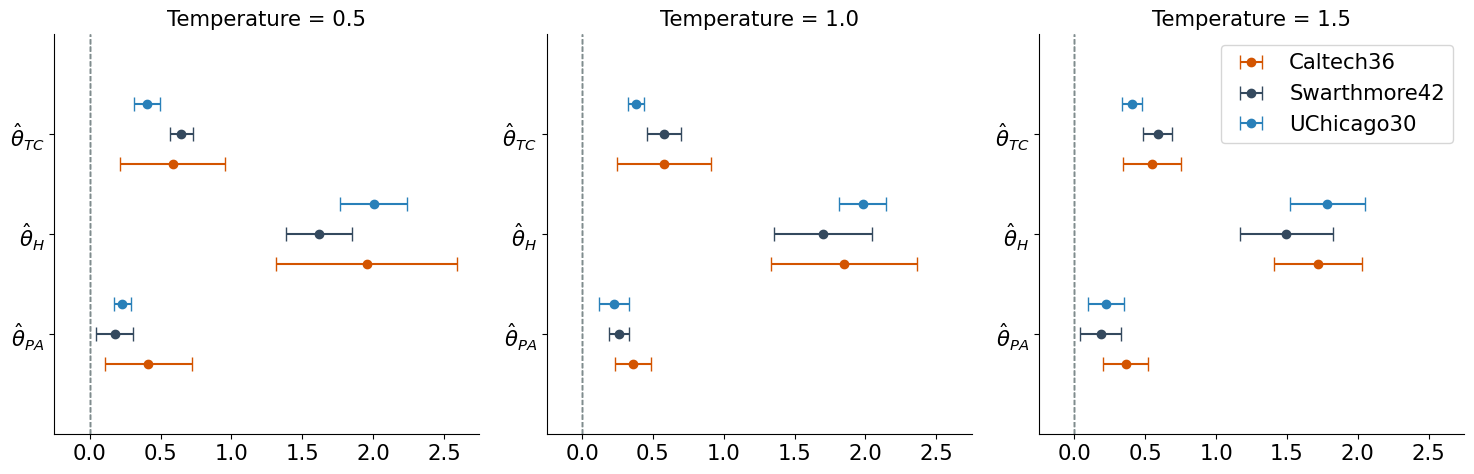

In [3]:
# Generate and format regression tables
# for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
#     for i in range(1, 4):
#         generate_regression_table(f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}.jsonl', f'tables/combined_model_facebook100_{name.lower()}_whole_{i}.xlsx')

# Export regression tables to LaTeX
for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
    for full in [True, False]:
        pretty_print_regression_table([f'tables/combined_model_facebook100_{name.lower()}_whole_{i}.xlsx' for i in range(1, 4)], f'tables/combined_model_facebook100_{name.lower()}{"_full" if full else ""}.tex', full=full)

plot_coefficients([f'tables/combined_model_facebook100_{name.lower()}_whole_{i}.xlsx' for i in range(1, 4) for name in ['Caltech36', 'Swarthmore42', 'UChicago30']], f'figures/combined_model_facebook100_coefficients.png')

In [4]:
# Community structure
# for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
#     modularity_change([f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}.jsonl' for i in range(1, 4)], subgraph=False)
#     if name == 'UChicago30':
#         modularity_change([f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}.jsonl' for i in range(1, 4)], subgraph=True)

In [5]:
# for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
#     small_worldness([f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}.jsonl' for i in range(1, 4)], name, subgraph=False)

In [6]:
# Relative increase in accuracy compared to random baseline

# for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
#     measure_relative_increase([f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}_small.jsonl' for i in range(1, 4)])

In [7]:
# LLM reasoning

# categories = [{'category' : 'Number of friends', 'description' : 'Large number of friends'},
#               {'category' : 'Mutual friends', 'description' : 'Large number of mutual friends'},
#               {'category' : 'Similar attributes', 'description' : 'Similar attributes such as major, faculty status, etc.'}]

# for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
#     summarize_reasons([f'outputs/combined_model_facebook100_{name.lower()}_whole_{i}.jsonl' for i in range(1, 4)], 'UChicago30', n_samples=20, n_categories=3, n_resamples=2, categories=categories)